**Author:** Elias Rafael Ruiz-Morales

**Institution:** Wellcome Sanger institute

**May, 2022**

Re-annotation of trophoblasts by including cell sub-types. I also calculate the marker genes of each cell identity and the DE genes of Explant vs Freash tissue.


----

# Notebook to annotate trophoblasts


In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import sys
import anndata

import matplotlib.pyplot as plt
import matplotlib as mpl


#For TF-IDF
import episcanpy as epi
from sklearn.feature_extraction.text import TfidfTransformer

In [2]:
#adata_ExplantNorm=sc.read('../results/scVI/S9_scVIintegrated_fetalSurgSubset_adata_latent20_20220523.h5ad')

In [2]:
def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = '../results/images/integrated/fetalSurgicalSubset/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1
legacy_api_wrap     0.0.0


'/opt/conda/bin/python'

In [4]:
def identityTransfer(adata_CellsNewID, adata, field='identity'):
    
    '''
    Function to transfer the value in a .obs column, modifying only the cells included in adata_CellsNewID
    
    Parameters:
        adata_CellsNewID: anndata object with cells. These should have in their .obs[field] the new values to be transfer to adata
        adata: anndata object to modify. The value in .obs[field] will be modifies for all the cells in adata_CellsNewID
        field: column name in .obs to operate in.
        
     Return:
        anndata object with the metadata modified
        
    '''
    
    #converting categorical into strings to introduce new categories
    adata.obs[field]=adata.obs[field].astype("string")


    #assigning the new categories to the cells in adata
    for cell in adata_CellsNewID.obs.index:
        adata.obs[field][cell] = adata_CellsNewID.obs[field][cell]

    #Returning strings into categorical 
    adata.obs[field]=adata.obs[field].astype("category")
    
    return(adata)

In [5]:
def runTF_IDF(adata, groupby, method='wilcoxon'):
    
    '''
    Function to run TF-IDF and DE analysis. TF-IDF means term-frequency times inverse document-frequency. 
    Its goal is to scale down the impact of tokens that occur very frequently (i.e. less informative)
    than features that occur in a small fraction of the training corpus.
    The the function applies a DE analysis.
    
    Parameters:
        adata: anndata object with cells.
        groupby: column name in .obs to make the DE comparison.
        method: method to use for Differential expression.
    
    Return:
        anndata object with the DE genes stored in adata.uns['rank_genes_groups']
        
    '''
    
    
    counts = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, asview=False)


    #-- Binarize counts matrix (1 if expressed, 0 otherwise)
    adata_bin = epi.pp.binarize(counts, copy=True)
    adata_bin.X.shape


    #-- Compute TF-IDF
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(adata_bin.X.T)
    adata_bin.X = tfidf.T
    adata_bin.X.shape


    #-- Compute Mann-Withney test with scanpy
    sc.tl.rank_genes_groups(adata_bin, groupby= groupby, use_raw=False, method=method)

    return(adata_bin)

In [6]:
def Barplot(which_var, adata, var='identity', height=3, color = False, suffix= ''):
    
    '''
    Function to plot barplots plotting the proportion of cells per catergory in var, coming from each category in which_var.
    
    Parameters:
        which_var: column name in .obs. Contains the categories to contrast.
        adata: anndata object.
        var: column name in .obs. It contains the categories of the cells.
        height: plot height
        color: colors to use
        suffix: string. Suffix to be added at the end of the name of the plot.
    
    Return:
        Saves bar plot as a pdf.
        
    '''
    
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+ suffix+'.pdf', bbox_inches='tight',
                       dpi=300, orientation='landscape', format= 'pdf', optimize=True)

## Loading data

In [7]:
#reading the modified object
adata=sc.read('../results/scVI/S9_scVIintegrated_fetalSurgSubset_adata_latent20_20220523.h5ad')

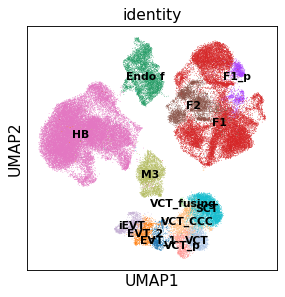

In [8]:
# use scVI imputed values for plotting
sc.pl.umap(adata, color=['identity' ], legend_loc='on data',legend_fontsize='x-small')

In [9]:
adata.layers['raw_counts']

<72027x32743 sparse matrix of type '<class 'numpy.float32'>'
	with 327032521 stored elements in Compressed Sparse Row format>

In [10]:
adataRef=adata.copy()

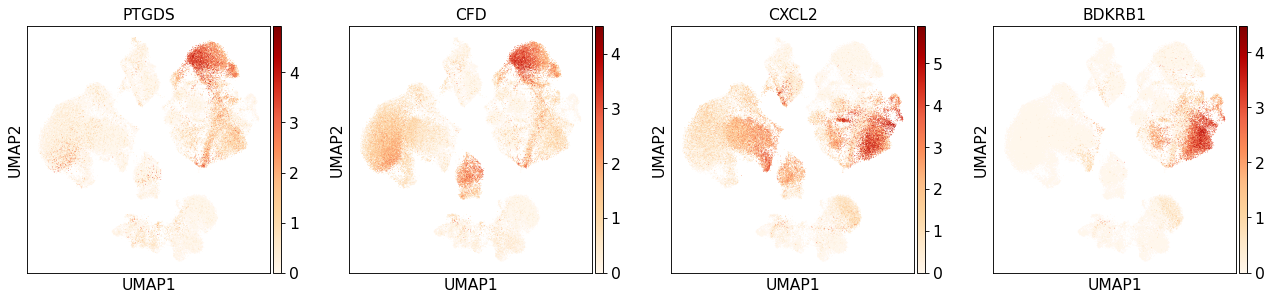

In [11]:
sc.pl.umap(adataRef, color=['PTGDS', 'CFD', 'CXCL2','BDKRB1'], color_map='OrRd')

In [12]:
adataRef.X=adataRef.layers['raw_counts']

In [13]:
adataRef

AnnData object with n_obs × n_vars = 72027 × 32743
    obs: 'sample', 'donor', 'termination', 'day', 'pcw', 'percent_mito', 'n_counts', 'batch', 'n_genes', 'sample_barcode', 'souporcell_id', 'donor_deconv', 'donor_souporcell', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'scrublet_doublet', 'leiden_scvi', 'celltype_predictions', 'probabilities', 'souporcell_MFgenotype', 'identity', 'souporcell_MFidentity', 'Tissue_type', 'identity_broad'
    var: 'gene_ids', 'feature_types', 'n_cells'
    uns: 'Tissue_type_colors', '_scvi', 'day_colors', 'donor_souporcell_colors', 'identity_broad_colors', 'identity_colors', 'leiden', 'leiden_scvi_colors', 'neighbors', 'pcw_colors', 'phase_colors', 'sample_colors', 'umap'
    obsm: 'X_scVI_n_latent_10', 'X_scVI_n_latent_20', 'X_scVI_n_latent_30', 'X_scVI_n_latent_40', 'X_umap', '_scvi_extra_categorical

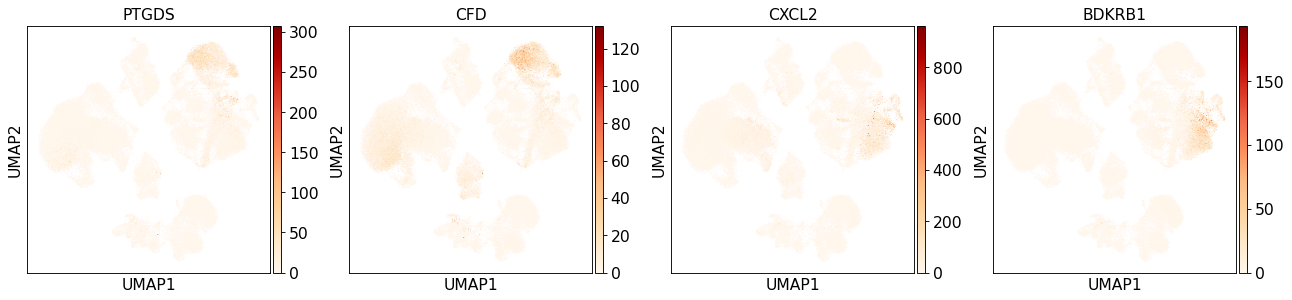

In [14]:
sc.pl.umap(adataRef, color=['PTGDS', 'CFD', 'CXCL2','BDKRB1'], color_map='OrRd')

In [15]:
print(adataRef.layers['raw_counts'][:20,:20])

  (0, 4)	1.0
  (3, 4)	2.0
  (3, 11)	1.0
  (3, 13)	1.0
  (3, 19)	1.0
  (5, 9)	1.0
  (6, 4)	1.0
  (6, 11)	1.0
  (6, 19)	1.0
  (9, 19)	1.0
  (10, 13)	1.0
  (13, 13)	1.0
  (13, 14)	1.0
  (13, 19)	2.0
  (16, 2)	1.0
  (16, 11)	2.0
  (17, 19)	1.0
  (18, 2)	1.0
  (18, 4)	1.0
  (19, 11)	1.0
  (19, 19)	1.0


In [16]:
print(adataRef.X[:10,:10])

  (0, 4)	1.0
  (3, 4)	2.0
  (5, 9)	1.0
  (6, 4)	1.0


In [17]:
print(adataRef.X[:10,:10])

  (0, 4)	1.0
  (3, 4)	2.0
  (5, 9)	1.0
  (6, 4)	1.0


### Re-annotating the Trophoblast sub-populations

I will explore the annotation reported Anna Arutyunyan:

 

In [18]:
Trophoblasts=sc.read('../results/scVI/S9_scVIintegrated_Trophoblasts_latent20_20220523.h5ad')

In [19]:
Trophoblasts.obs['leiden_scvi2']= Trophoblasts.obs['leiden_scvi']

In [20]:
#LATENT 30
sc.pp.neighbors(Trophoblasts, n_neighbors=15, use_rep="X_scVI_n_latent_20")
sc.tl.umap(Trophoblasts)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:31)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


running Leiden clustering
    finished: found 13 clusters and added
    'leiden_scvi', the cluster labels (adata.obs, categorical) (0:00:01)


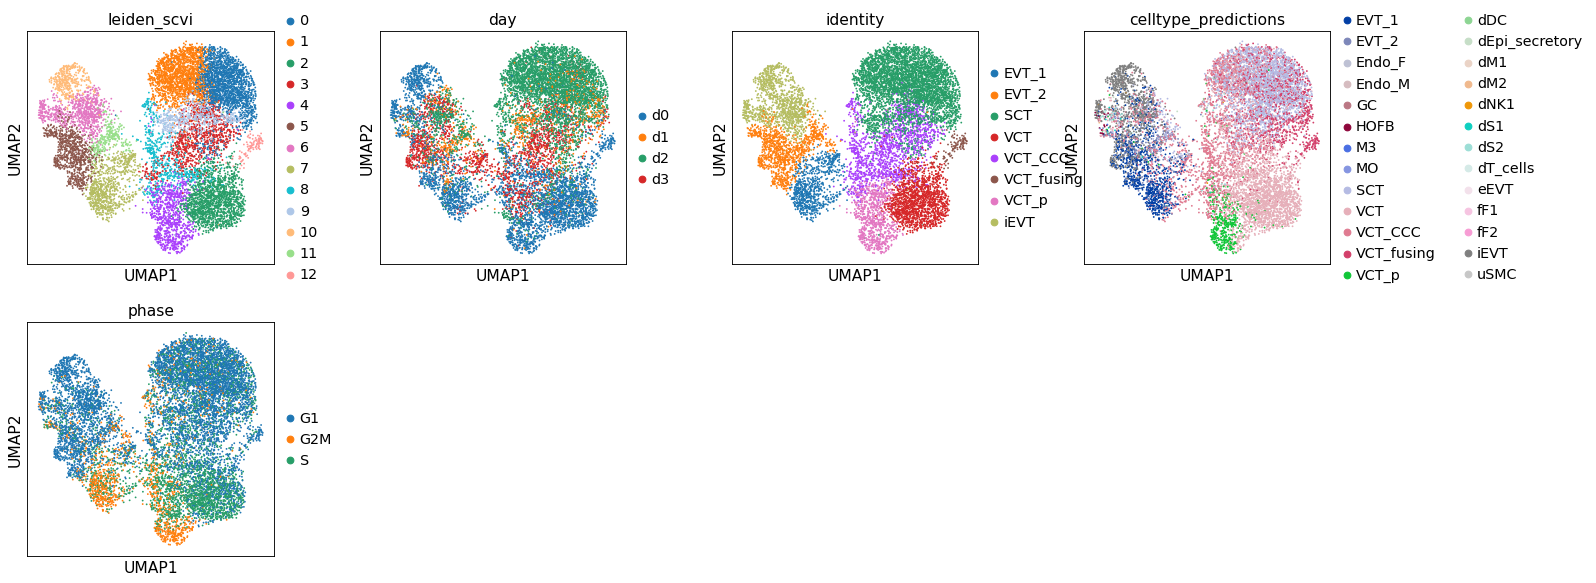

In [21]:
#clustering
sc.tl.leiden(Trophoblasts, key_added="leiden_scvi", resolution=0.8)


sc.pl.umap(Trophoblasts, color=["leiden_scvi",'day', 'identity','celltype_predictions','phase'],
           wspace=0.3,)

In [48]:
#Loading the predictions done using all the cells as training set, and only the
# Trophoblast as test set

#prediction= pd.read_csv('../results/log_regression/logreg_from_P13_trophoblast_to_explant_premrna_HVGs_predictions_20220124.csv', index_col=0)

In [15]:
##----- Trying with prediction using the newest MFI data set
##----- but only the Trophoblasts as training set

In [22]:
#Loading the prediction
prediction= pd.read_csv('../results/log_regression/logreg_trophoblastOnly_to_explant_premrna_HVGs_predictions_20220523.csv', index_col=0)

In [23]:
prediction

celltype_predictions  probabilities
Pla_HDBR10917730_AAACCCAGTAGCTCGC                  SCT       0.999993
Pla_HDBR10917730_AAAGGTATCAAGGTGG                  SCT       0.545149
Pla_HDBR10917730_AACAACCCACAATGTC                  SCT       0.999899
Pla_HDBR10917730_ACACTGAAGGTACCTT           VCT_fusing       0.999362
Pla_HDBR10917730_ACCACAATCATAAGGA           VCT_fusing       0.999987
...                                                ...            ...
Pla_HDBR12808831_TTGTGGAAGCTGAGCA                  SCT       0.878138
Pla_HDBR12808831_TTGTTTGCACTGCGTG                  SCT       0.545586
Pla_HDBR12808831_TTTATGCCAGTCAACT                EVT_2       0.995559
Pla_HDBR12808831_TTTCACAAGTGATGGC                EVT_2       0.927681
Pla_HDBR12808831_TTTGTTGGTACACGCC                EVT_2       0.981388

[11324 rows x 2 columns]

In [24]:
#Changing names to differentiate from the ol predictions
prediction['celltype_predictions2']= prediction['celltype_predictions']
prediction['probabilities2']= prediction['probabilities']

prediction= prediction.drop(columns=['celltype_predictions', 'probabilities'])

In [ ]:
#Adding the predictions to the metadata
Trophoblasts.obs= Trophoblasts.obs.join(prediction)

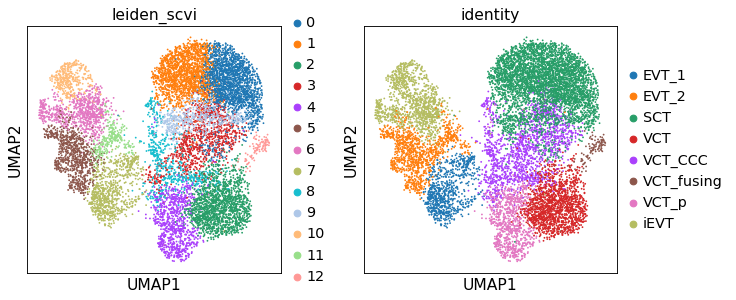

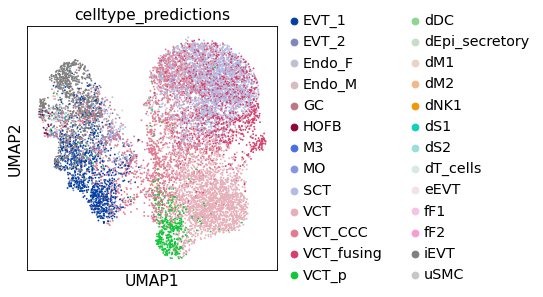

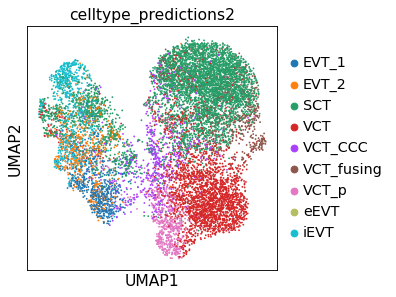

In [26]:
sc.pl.umap(Trophoblasts, color=["leiden_scvi", 'identity'])
sc.pl.umap(Trophoblasts, color=['celltype_predictions'])
sc.pl.umap(Trophoblasts, color=['celltype_predictions2'])



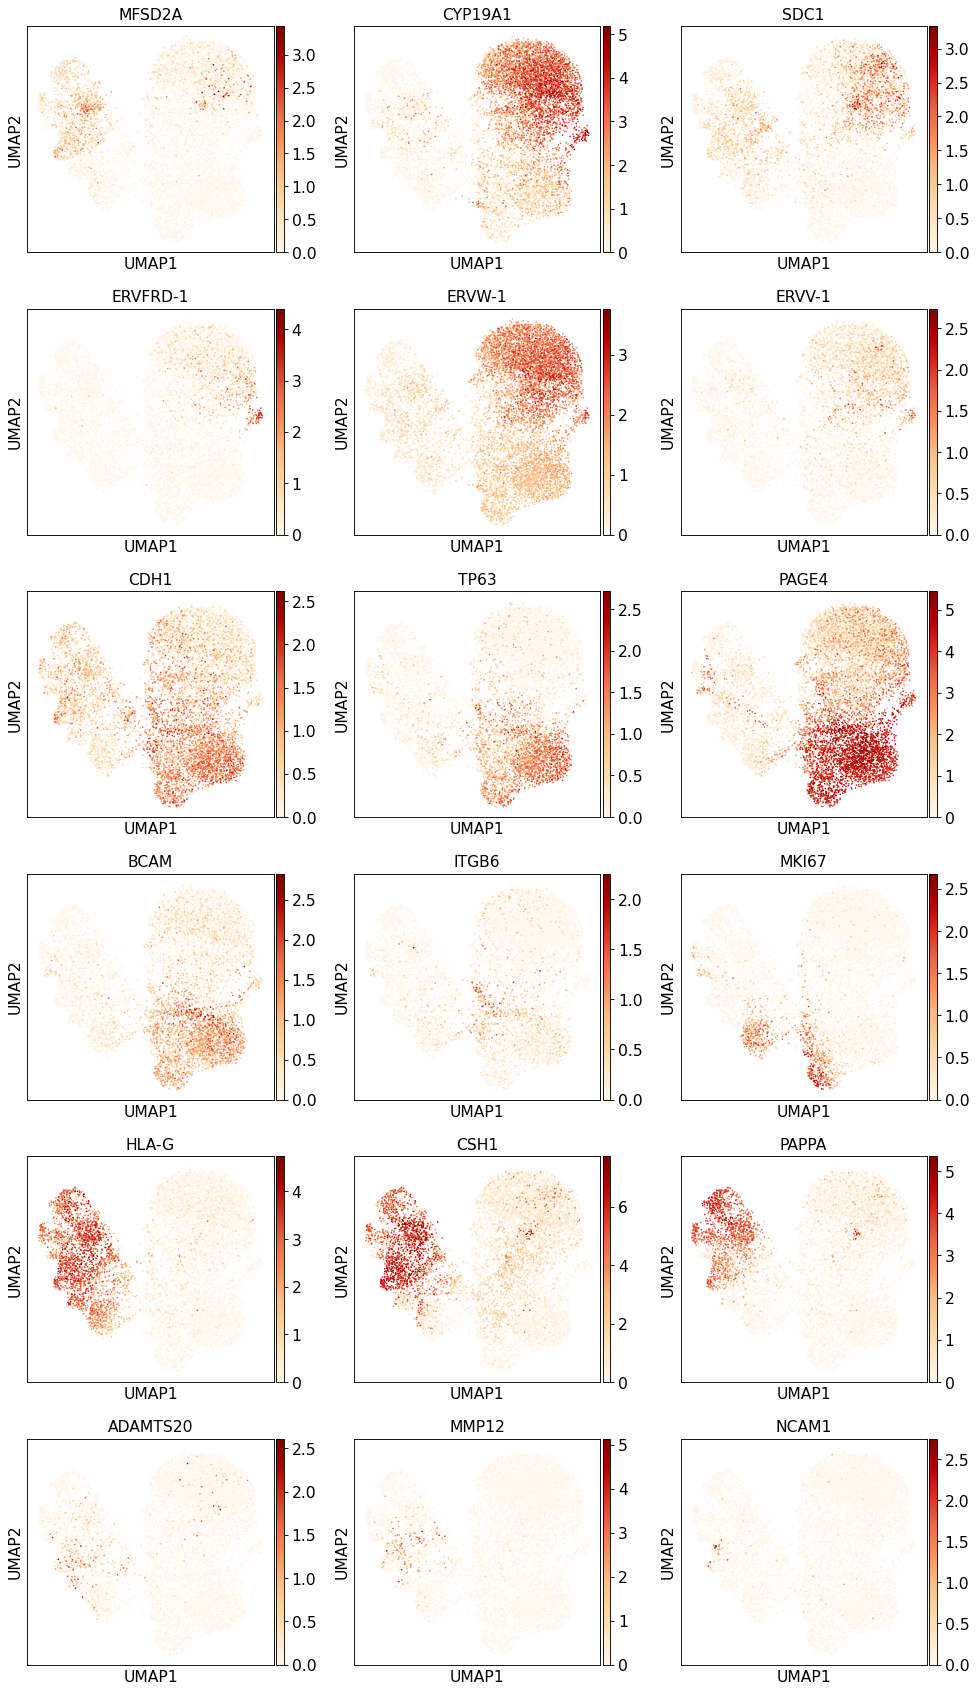

In [30]:
sc.pl.umap(Trophoblasts, color=['MFSD2A', #SCT
                                'CYP19A1','SDC1',#VCT-fusing & SCT
                                'ERVFRD-1','ERVW-1','ERVV-1', #VCT-fusing
                                'CDH1','TP63','PAGE4','BCAM',  #VCT
                                'ITGB6',#VCT-CCC
                                'MKI67', #VCT-P
                         'HLA-G', 'CSH1', 'PAPPA',#EVT
                         'ADAMTS20', #EVT1/2
                         'MMP12','NCAM1',  #eEVT
                         ], color_map='OrRd', size=8, ncols=3)

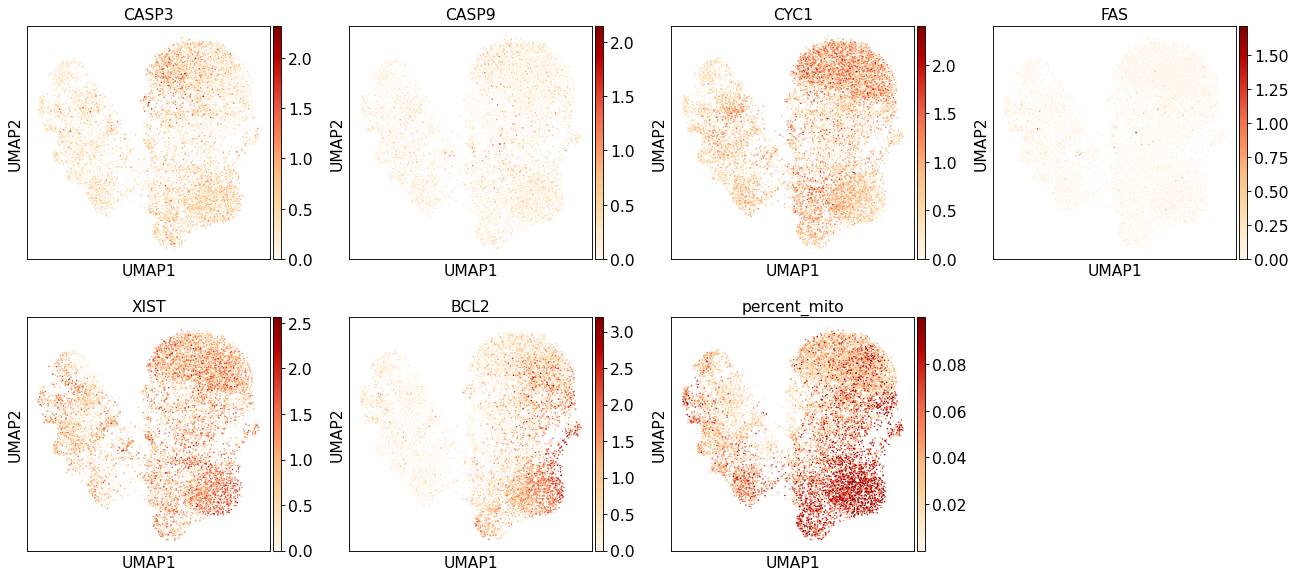

In [29]:
sc.pl.umap(Trophoblasts, color=['CASP3', 'CASP9', 'CYC1','FAS','XIST','BCL2', 'percent_mito'],
           color_map='OrRd', size=7)

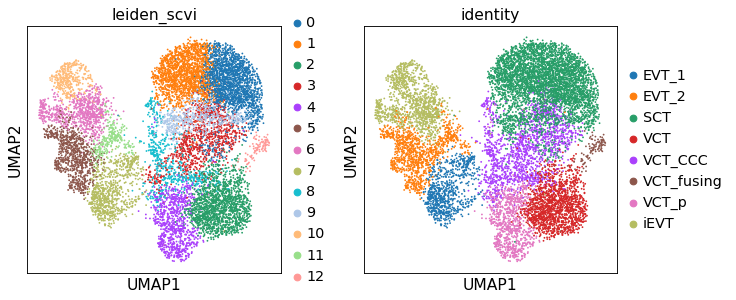

In [27]:
sc.pl.umap(Trophoblasts, color=["leiden_scvi", 'identity'])

In [31]:
#COpying the value of the leiden cluster. The new column will help to change it's values for
# the cluster identity
Trophoblasts.obs['identity']= Trophoblasts.obs['leiden_scvi']


#Function that changes the cluster names as indicated
Trophoblasts.obs['identity'] = (Trophoblasts.obs["leiden_scvi"].map(lambda x: 
                            {"0": "VCT_fusing", "1": "VCT_fusing", "2": "VCT", "3": "VCT_CCC", "4": "VCT_p","5": "EVT_2",
                            "6": "iEVT", "7": "EVT_1", "8": "VCT_CCC", "9": "VCT_fusing", "10": "iEVT",
                            "11": "EVT_2", "12": "VCT_fusing"}
                            .get(x, x)).astype("category"))

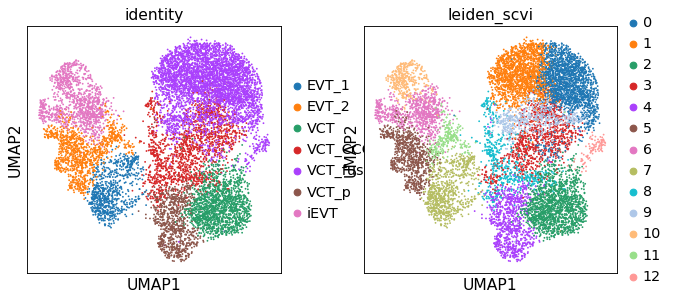

In [32]:
sc.pl.umap(Trophoblasts, color=['identity',"leiden_scvi"])

In [33]:
#Saving the modified object
Trophoblasts.write('../results/scVI/S9_scVIintegrated_Trophoblasts_latent20_20220523.h5ad')

In [34]:
#Assigning the old leiden cluster name to the original column. This to avoid confusions in the object
Trophoblasts.obs['leiden_scvi']= Trophoblasts.obs['leiden_scvi2']

#Removing the temp column that keep the old
Trophoblasts.obs= Trophoblasts.obs.drop(columns=['leiden_scvi2'])

In [35]:
#Removing the columns from the newer predictions to keep the old one
Trophoblasts.obs= Trophoblasts.obs.drop(columns=['celltype_predictions2'])

Trophoblasts.obs= Trophoblasts.obs.drop(columns=['probabilities2'])

In [36]:
#Updating the new Trophoblast annotation into the big data set
adata= identityTransfer(Trophoblasts, adata)

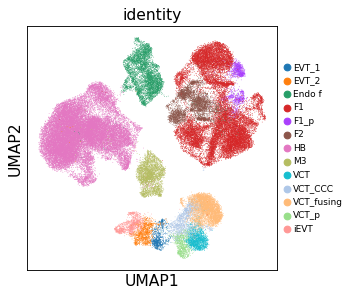

In [37]:
# use scVI imputed values for plotting
sc.pl.umap(adata, color=['identity' ], legend_fontsize='xx-small') #legend_loc='on data',

In [69]:
#Assigning the old leiden cluster name to the original column. This to avoid confusions in the object
adata.obs['identity_broad']= adata.obs['identity']



#Function that changes the cluster names as indicated
adata.obs['identity_broad'] = (adata.obs["identity"].map(lambda x: 
                            {"EVT_1": "EVT", "EVT_2": "EVT", "Endo f": "Endo_f", "F1": "F1", "F1_p": "F1","F2": "F2",
                            "HB": "HB", "VCT": "VCT", "VCT_CCC": "VCT", "VCT_fusing": "VCT",
                            "VCT_p": "VCT", "iEVT": "EVT"}
                            .get(x, x)).astype("category"))

### Changing the F annotations:
F1_p = F1

In [70]:

#Function that changes the cluster names as indicated
adata.obs['identity'] = (adata.obs["identity"].map(lambda x: 
                            {"EVT_1": "EVT_1", "EVT_2": "EVT_2", "Endo f": "Endo_f", "F1": "F1", "F1_p": "F1", "F2": "F2",
                            "HB": "HB", "VCT": "VCT", "VCT_CCC": "VCT_CCC", "VCT_fusing": "VCT_fusing",
                            "VCT_p": "VCT_p", "iEVT": "iEVT"}
                            .get(x, x)).astype("category"))

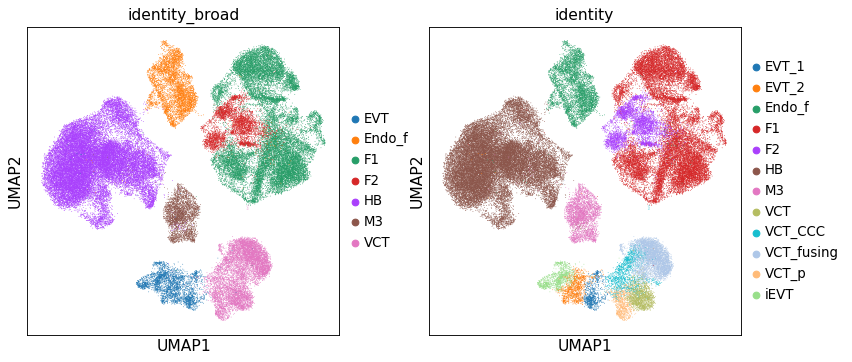

In [71]:
sc.pl.umap(adata, color=['identity_broad','identity' ],legend_fontsize=12, size=2)

## Saving the object

In [41]:
#removing the .raw instance
adata.raw= None

In [49]:
adata.X=adata.layers['raw_counts'].copy()

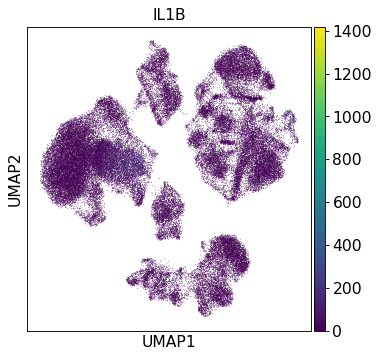

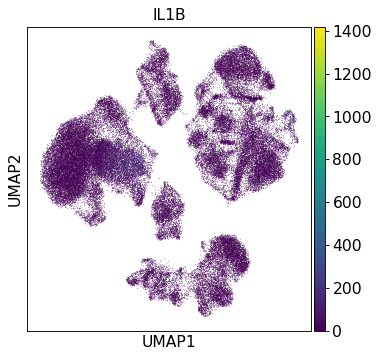

In [63]:
# use scVI imputed values for plotting
sc.pl.umap(adata, color=['IL1B' ],legend_fontsize='xx-small', layer='raw_counts')
sc.pl.umap(adata, color=['IL1B' ],legend_fontsize='xx-small', use_raw=False)

In [72]:
#Saving the modified object
adata.write('../results/scVI/S9_scVIintegrated_fetalSurgSubset_adata_latent20_20220523.h5ad')

In [ ]:
#adata=sc.read('../results/scVI/S9_scVIintegrated_fetalSurgSubset_adata_latent20_20220523.h5ad')

### Setting up color palette for future plots

In [65]:
sc.set_figure_params(figsize=(5,5))

In [73]:
#DF with the row names as the identity of the cells
colors_final_df = pd.DataFrame(index = np.unique(adata.obs['identity']))


#Assign each color per cell type under the column color

#colors_final_df.loc['SCT', 'color'] = '#f779a3'
colors_final_df.loc['VCT', 'color'] = '#b27ab4'
colors_final_df.loc['VCT_fusing', 'color'] = '#b53179'
colors_final_df.loc['VCT_p', 'color'] = '#993f98'
colors_final_df.loc['VCT_CCC', 'color'] = '#e2a7c8'

colors_final_df.loc['iEVT', 'color'] = '#0069b4'
colors_final_df.loc['EVT_1', 'color'] = '#009999'
colors_final_df.loc['EVT_2', 'color'] = '#03f9f2'


colors_final_df.loc['Endo_f', 'color'] = '#3f752d'
colors_final_df.loc['F1', 'color'] = '#6bb300'
colors_final_df.loc['F2', 'color'] = '#d6ff99'

colors_final_df.loc['HB', 'color'] = '#f7e55e'
colors_final_df.loc['M3', 'color'] = '#db5669'

colors_final_dict= colors_final_df.to_dict()['color']

In [74]:
colors_final_df

color
EVT_1       #009999
EVT_2       #03f9f2
Endo_f      #3f752d
F1          #6bb300
F2          #d6ff99
HB          #f7e55e
M3          #db5669
VCT         #b27ab4
VCT_CCC     #e2a7c8
VCT_fusing  #b53179
VCT_p       #993f98
iEVT        #0069b4

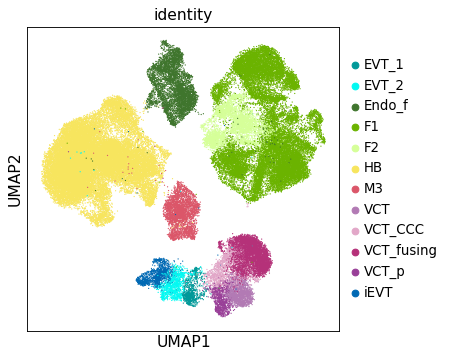

In [75]:
sc.pl.umap(adata,  color=['identity'], palette= colors_final_dict, legend_fontsize=12, size=5)

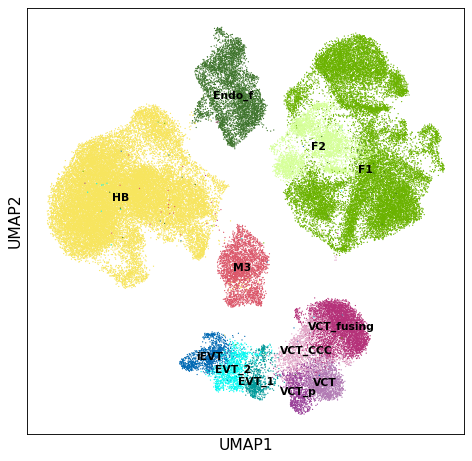

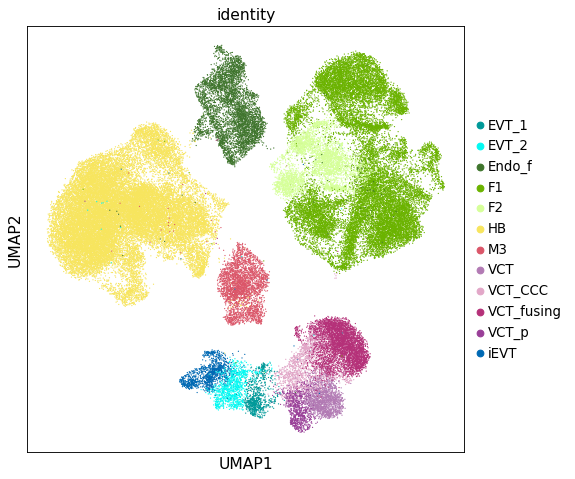

In [76]:
sc.set_figure_params(figsize=(7,7))
sc.pl.umap(adata, color=['identity' ],size=5, title='', legend_loc='on data',legend_fontsize='x-small',  
          palette= colors_final_dict, save='_scVI_latent20_fetal_ondata.pdf')

sc.pl.umap(adata, color=['identity' ],legend_fontsize=12, size=5,
          palette= colors_final_dict, save='_scVI_latent20_fetal.pdf')

In [11]:
sc.set_figure_params(figsize=(7,7))



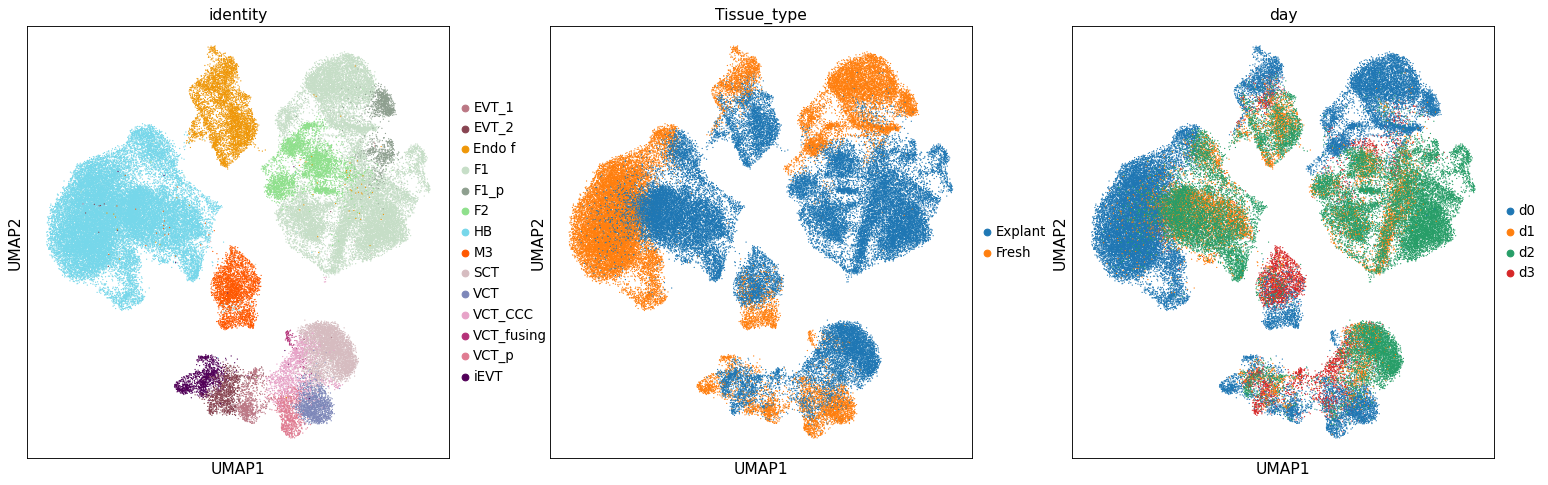

In [14]:
sc.pl.umap(adata, color=['identity','Tissue_type','day' ],legend_fontsize=12, size=5)

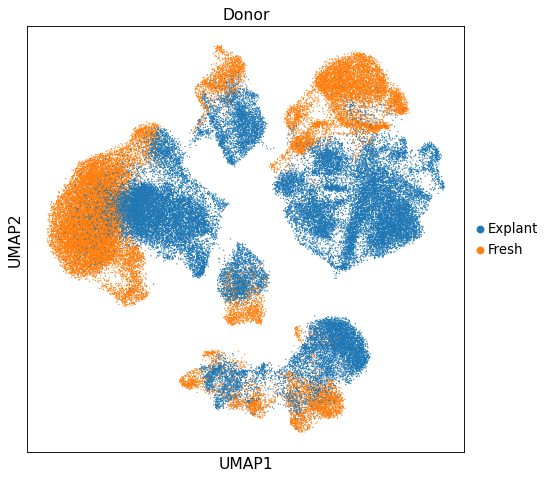

In [13]:
sc.pl.umap(adata, color=['Tissue_type' ],title='Donor',legend_fontsize=12, size=5, save='_scVI_latent20_fetal_TissueType.pdf')

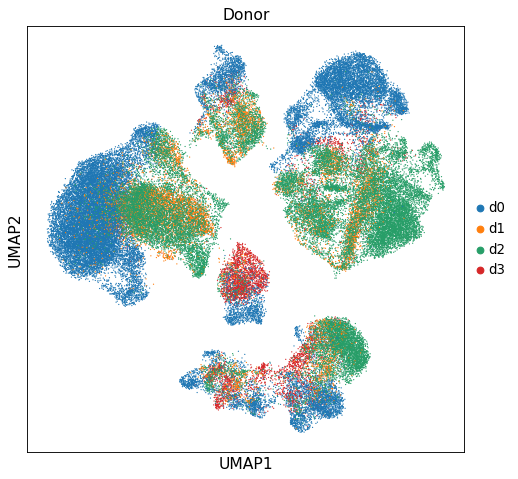

In [15]:
sc.pl.umap(adata, color=['day' ],title='Donor',legend_fontsize=12, size=5, save='_scVI_latent20_fetal_day.pdf')

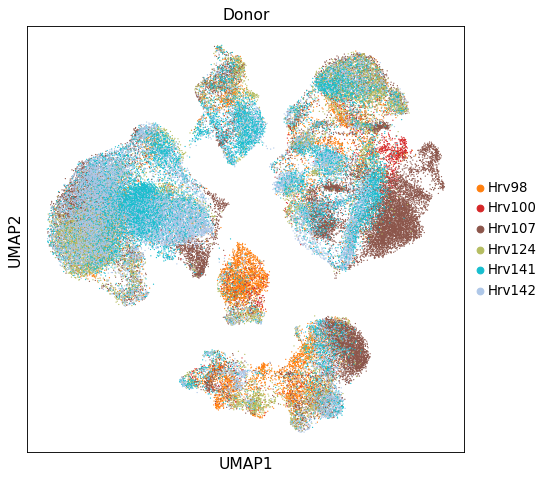

In [98]:
sc.pl.umap(adata, color=['donor_souporcell' ],title='Donor',legend_fontsize=12, size=5, save='_scVI_latent20_fetal_donors.pdf')